### Chargement des packages

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import dirichlet, norm
import random

# ARMA(p,q) with Dirichlet prior

## Chargement des données : série de longueur 30 ans

In [3]:
# N=55 pays, longueur T=30 ans (entre 1995 et 2024), normalisé entre 0 et 1 (par colonne et au global)
GDP_30 = pd.read_csv('../Data preprocessing/GDP_yearly_30_colnormalized', index_col=0)
GDP_global_30 = pd.read_csv('../Data preprocessing/GDP_yearly_30_global_normalized')

## Chargement des données : série de longueur 25 ans

In [4]:
# N=71 pays, longueur T=25 ans (entre 2000 et 2024), normalisé entre 0 et 1 (par colonne et au global)
GDP_25 = pd.read_csv('../Data preprocessing/GDP_yearly_25_colnormalized', index_col=0)
GDP_global_25 = pd.read_csv('../Data preprocessing/GDP_yearly_25_global_normalized')

## Chargement des données : série de longueur 27 ans

In [5]:
# N=60 pays, longueur T=27 ans (entre 1998 et 2024), normalisé entre 0 et 1 (par colonne et au global)
GDP_27 = pd.read_csv('../Data preprocessing/GDP_yearly_27_colnormalized', index_col=0)
GDP_global_27 = pd.read_csv('../Data preprocessing/GDP_yearly_27_global_normalized')

In [6]:
GDP_global_27.head()

,Argentina,Australia,Austria,Belgium,Bulgaria,Bolivia,Brazil,Botswana,Canada,Switzerland,...,Serbia,Slovakia,Slovenia,Sweden,Thailand,Turkey,"Taiwan, China",Uruguay,United States,South Africa
0,0.015091,0.040353,0.015689,0.018966,0.001303,0.000223,0.068021,0.000000,0.059044,0.022619,...,0.001117,0.002489,0.001340,0.017908,0.009008,0.024030,0.012430,0.001309,0.569929,0.012723
1,0.014574,0.042161,0.016277,0.019651,0.001162,0.000226,0.068341,0.000032,0.062099,0.022994,...,0.000960,0.002476,0.001428,0.018629,0.009443,0.023227,0.013293,0.001276,0.597243,0.013038
2,0.014459,0.043479,0.016847,0.020396,0.001227,0.000241,0.071309,0.000049,0.065310,0.023956,...,0.001045,0.002497,0.001500,0.019546,0.009881,0.024881,0.014157,0.001244,0.621610,0.013602
3,0.013802,0.044620,0.017069,0.020625,0.001290,0.000252,0.072368,0.000060,0.066542,0.024348,...,0.001138,0.002582,0.001556,0.019853,0.010234,0.023401,0.013953,0.001181,0.627553,0.013980
4,0.012267,0.046492,0.017327,0.020984,0.001387,0.000269,0.074568,0.000093,0.068550,0.024335,...,0.001238,0.002713,0.001618,0.020310,0.010887,0.024925,0.014740,0.001060,0.638232,0.014512


In [7]:
GDP_27.head()

,Argentina,Australia,Austria,Belgium,Bulgaria,Bolivia,Brazil,Botswana,Canada,Switzerland,...,Serbia,Slovakia,Slovenia,Sweden,Thailand,Turkey,"Taiwan, China",Uruguay,United States,South Africa
Year,,,,,,,,,,,,,,,,,,,,,
1998.0,0.465062,0.000000,0.000000,0.000000,0.078101,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.099174,0.004087,0.000000,0.000000,0.000000,0.015166,0.000000,0.193577,0.000000,0.000000
1999.0,0.419842,0.043460,0.075248,0.065662,0.000000,0.002935,0.006361,0.058236,0.071799,0.027176,...,0.000000,0.000000,0.059256,0.056431,0.036479,0.000000,0.043589,0.169978,0.063511,0.032060
2000.0,0.409848,0.075163,0.148157,0.136995,0.036144,0.021531,0.065312,0.089006,0.147254,0.096914,...,0.053878,0.006259,0.107926,0.128310,0.073154,0.031237,0.087227,0.146532,0.120167,0.089510
2001.0,0.352416,0.102593,0.176508,0.158882,0.070884,0.034685,0.086347,0.108492,0.176202,0.125390,...,0.112951,0.031499,0.145398,0.152396,0.102717,0.003282,0.076927,0.100792,0.133988,0.127994
2002.0,0.218249,0.147604,0.209524,0.193231,0.124303,0.054367,0.130058,0.168572,0.223374,0.124394,...,0.176114,0.070471,0.187079,0.188187,0.157387,0.032078,0.116652,0.012801,0.158818,0.182160


## Premier exemple avec p(yi∣θk) gaussienne 
(yi gaussienne de moyenne θk)

Les paramètres theta ne doivent pas être en dimension T + update du theta à reprendre avec la posterior

In [15]:
# --- Étape 1: Initialisation --- Distribution a priori
def initialize_model(y, K, e0=1.0):
    """
    Initialise les paramètres du modèle.
    y: Liste des séries temporelles [N x T]
    K: Nombre de groupes
    e0: Hyperparamètre du Dirichlet
    """
    N, T = y.shape
    eta = dirichlet.rvs([e0] * K, size=1).flatten()  # Dirichlet prior for eta
    S = np.random.choice(K, size=N)  # Random initial classification
    theta = [np.random.randn(T) for _ in range(K)]  # Paramètres pour chaque groupe
    return eta, S, theta

In [16]:
# --- Étape 2: Échantillonnage de S ---
def sample_S(y, theta, eta):
    """
    Échantillonne les indicateurs de groupe S.
    """
    N = len(y)
    K = len(theta)
    S = np.zeros(N, dtype=int)
    for i in range(N):
        probs = [
            norm.pdf(y[i], loc=theta[k]).prod() * eta[k]  # Probabilité conditionnelle p(yi∣θk) gaussienne
            for k in range(K)
        ]
        probs = np.array(probs)
        probs /= probs.sum()  # Normalisation
        S[i] = np.random.choice(K, p=probs)  # Échantillonnage
    return S

Remarque : Dans la fonction précédente, on fait l'hypothèse d'indépendance conditionnelle, c'est-à-dire que l'on suppose les dimensions de 𝑦[𝑖] indépendantes étant donné 𝜃[𝑘]. Cela permet de calculer la probabilité jointe comme le produit des densités marginales.

In [17]:
# --- Étape 3: Mise à jour des paramètres ---
def update_theta(y, S, K):
    """
    Met à jour les paramètres spécifiques aux groupes (theta) en fonction des données de l'affectation actuelle.
    """
    T = y.shape[1]
    theta = []
    for k in range(K):
        group_data = y[S == k]   # Contient toutes les séries appartenant au groupe k
        if len(group_data) > 0:
            theta_k = group_data.mean(axis=0)  # Posterior mean (simple estimation)
        else:
            theta_k = np.random.randn(T)  # Cas sans données : valeur aléatoire d'une distribution gaussienne standard
        theta.append(theta_k)
    return theta

def update_eta_ignorance_structure(S, K, e0=1.0):
    """
    Met à jour les probabilités a priori des paramètres eta (structure d'ignorance) influencées  par la distribution actuelle des affectations S.
    """
    counts = np.bincount(S, minlength=K) + e0  # Comptes augmentés par le prior (nombre d'observations assignées à chaque groupe k + e0)
    return dirichlet.rvs(counts, size=1).flatten()

In [20]:
# --- Étape 4: MCMC ---
def mcmc(y, K, num_iter=1000, e0=1.0):
    """
    Effectue l'estimation via MCMC.
    """
    eta, S, theta = initialize_model(y, K, e0)
    for iteration in range(num_iter):
        # Échantillonnage de S
        S = sample_S(y, theta, eta)
        # Mise à jour de theta
        theta = update_theta(y, S, K)
        # Mise à jour de eta
        eta = update_eta_ignorance_structure(S, K, e0)
    return S, theta, eta

In [ ]:
# Exécution pour des données synthétiques

# Génération de données synthétiques
np.random.seed(42)
N, T, K = 100, 50, 3
true_theta = [np.random.randn(T) for _ in range(K)]
y = np.vstack([np.random.randn(1, T) + true_theta[k] for k in np.random.choice(K, N)])

# Estimation MCMC
S_est, theta_est, eta_est = mcmc(y, K, num_iter=500)

print("Classification estimée : ", S_est)
print("Paramètres des groupes : ", theta_est)
print("Paramètres eta : ", eta_est)

Classification estimée :  [1 2 0 2 1 1 0 1 2 0 2 2 1 1 1 1 1 0 2 2 2 2 1 2 0 0 2 2 0 0 1 0 1 1 1 1 1
 2 0 1 0 0 1 2 1 2 0 2 2 2 0 0 2 2 1 2 1 2 1 0 2 2 2 2 1 2 0 0 2 0 2 2 0 2
 0 1 2 1 0 1 1 0 1 1 0 1 0 1 0 0 1 1 1 2 2 2 0 1 0 2]
Paramètres des groupes :  [array([-1.43885876, -0.28508876,  0.07423943, -0.56848096, -0.06911439,
        0.84361014,  1.71529438,  0.00278895, -0.04675652, -0.21411054,
       -1.91502398, -0.17995909,  0.53696021,  2.1140656 ,  0.09221716,
        0.31718667,  0.1964794 , -1.17957364,  0.94882226,  0.83776001,
        0.85822083, -0.91832784,  1.35476824, -1.33344936,  0.48575812,
        2.03911007, -1.10031333, -0.40622436,  0.24109638, -0.6489704 ,
       -1.97050145,  0.09435958, -0.91618468,  0.39386854, -0.93195056,
        1.21101961, -0.66223164, -0.34742302,  0.88112607, -1.15063722,
        0.18146311,  1.35918336, -1.64153013,  0.34284287,  0.40648783,
        0.99553769, -1.35064288, -1.24120905,  0.54834596,  0.32916065]), array([ 0.54155319, -

In [22]:
y # à tracer 

array([[-0.34285941, -2.07690054, -0.02012467, ..., -0.55421566,
         0.70420584,  0.3653095 ],
       [ 0.01546602, -2.23205831,  0.22764107, ...,  1.28610076,
        -1.19044683, -1.39997055],
       [-0.27099921,  0.43721934, -0.96957239, ..., -0.78443008,
         1.36211272,  1.4303267 ],
       ...,
       [ 0.51450932, -1.07085069, -1.79038001, ..., -1.84184646,
        -0.20222532,  0.68043279],
       [-1.33553995, -1.58544234, -0.24076355, ..., -3.07086435,
         0.7562848 ,  1.25141375],
       [-0.98886192,  1.51990591, -0.36214154, ...,  0.70992497,
         0.58586527, -3.68414091]])

In [30]:
y.shape

(100, 50)

In [63]:
# Exécution pour des données réelles normalisées

np.random.seed(42)

# Conversion en tableau NumPy
y = GDP_global_25.values.T  # Transpose pour avoir (N, T)
print(y.shape)  

K = 3  # Nombre de clusters
num_iter = 500  # Nombre d'itérations pour le MCMC

# Estimation MCMC
S_est, theta_est, eta_est = mcmc(y, K, num_iter)

print("Classification estimée : ", S_est)
print("Paramètres des groupes : ", theta_est)
print("Paramètres eta : ", eta_est)

(69, 27)
Classification estimée :  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Paramètres des groupes :  [array([-0.3042521 , -0.11670463, -0.3473727 , -0.53600333, -0.30915443,
       -0.27934743,  0.89081317, -0.89444088,  1.9536459 , -0.66514828,
        0.86910079, -1.42708004, -0.66648318, -0.22104584, -0.86772683,
        0.57914114,  0.56361525, -0.70822635, -1.81519983,  0.62686454,
        0.07987199, -0.48536948, -0.57860071, -0.70380732,  0.84741842,
       -0.33620734,  1.37977526]), array([0.03085638, 0.06074844, 0.11206989, 0.13884558, 0.16606907,
       0.20141824, 0.25704613, 0.31076316, 0.3797597 , 0.45083692,
       0.48009911, 0.42329402, 0.47721469, 0.51991825, 0.53946059,
       0.57033192, 0.60810629, 0.64955105, 0.69165072, 0.75201168,
       0.8053718 , 0.84722232, 0.75697621, 0.88197098, 0.95204807,
       0.98845817, 0.41973416]), array([ 2.37127377,  0.66286393,  

In [ ]:
# Exécution pour des données réelles normalisées sur l'ensemble

np.random.seed(42)

# Conversion en tableau NumPy
y_global = GDP_global_30.values.T  # Transpose pour avoir (N, T)
print(y.shape)  

K = 3  # Nombre de clusters
num_iter = 500  # Nombre d'itérations pour le MCMC

# Estimation MCMC
S_est, theta_est, eta_est = mcmc(y_global, K, num_iter)

print("Classification estimée : ", S_est)
print("Paramètres des groupes : ", theta_est)
print("Paramètres eta : ", eta_est)

Classification estimée :  [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Paramètres des groupes :  [array([ 1.74169077e+00, -3.81474571e-01,  4.25480967e-01,  1.09195970e+00,
       -1.89837742e+00, -8.37492785e-01, -1.23806434e-03, -1.18768745e+00,
       -6.75776988e-01, -1.79102207e+00, -9.14564488e-01, -8.18783113e-01,
        1.62320855e+00,  6.30259872e-01, -1.36151115e+00, -5.45606038e-01,
        3.16015286e-01, -7.85183851e-01, -6.70778772e-01,  1.63083555e+00,
       -1.22885632e+00,  2.08056312e+00, -1.24419540e+00, -2.11153265e+00,
        1.62670924e+00,  2.98005680e-01, -1.55600629e-01]), array([ 3.86532725e-01, -1.44286948e+00, -5.56678995e-01,  9.53890045e-01,
       -6.86679973e-01, -7.04344431e-01,  1.15052783e+00, -5.36561176e-02,
        3.52715559e-01, -1.42268760e+00,  1.60169876e-03,  1.38842350e+00,
       -1.80436284e+00, -9.76998604e-01,  1.21490237e+00,  3.84131575e-

## Deuxième exemple avec un modèle ARMA(p, q)

1) Mise à jour des paramètres selon la posterior avec ARMA + calculer p(y_i | theta_k) pour un modèle ARMA

2) Chercher prior logit avec K > 2

3) Vérifier la posterior Dirichlet

4) Revoir estimation du nb de clusters optimal et bridge sampling

In [79]:
from statsmodels.tsa.arima.model import ARIMA

In [80]:
def arma_log_likelihood(y, theta, p, q):
    """
    Calcule la vraisemblance logarithmique d'un modèle ARMA.
    y : série temporelle
    theta : paramètres ARMA
    """
    # Placeholder : remplacer par une vraie implémentation
    return -0.5 * np.sum((y - np.convolve(y, theta, mode='same'))**2)

def sample_S_arma(y, theta, eta, p, q):
    """
    Échantillonne les indicateurs de groupe S.
    y : séries temporelles
    theta : paramètres ARMA pour chaque groupe
    eta : probabilités de groupe
    """
    N = len(y)
    K = len(eta)
    log_probs = np.zeros((N, K))
    
    for k in range(K):
        for i in range(N):
            log_probs[i, k] = np.log(eta[k]) + arma_log_likelihood(y[i], theta[k], p, q)
    
    # Normalisation pour obtenir des probabilités
    probs = np.exp(log_probs - log_probs.max(axis=1, keepdims=True))
    probs /= probs.sum(axis=1, keepdims=True)

    # Échantillonnage des groupes
    S = np.array([np.random.choice(K, p=probs[i]) for i in range(N)])
    return S

def estimate_arma_params(y, p, q):
    """
    Estime les paramètres ARMA pour un ensemble de séries.
    """
    # Placeholder : remplacer par une vraie implémentation
    return np.random.randn(p + q)

def update_theta_arma(y, S, K, p, q):
    """
    Met à jour les paramètres ARMA pour chaque groupe.
    """
    theta = []
    for k in range(K):
        group_data = y[S == k]  # Séries assignées au groupe k
        theta_k = estimate_arma_params(group_data, p, q)
        theta.append(theta_k)
    return theta

In [77]:
def mcmc_arma(y, K, p, q, num_iterations, e0=1.0):
    """
    Exécute une chaîne MCMC pour estimer les paramètres du modèle ARMA avec structure d'ignorance pour eta.
    y : séries temporelles (array [N x T])
    K : nombre de groupes
    p : ordre AR
    q : ordre MA
    num_iterations : nombre d'itérations de MCMC
    e0 : hyperparamètre de la distribution Dirichlet pour eta
    """
    # Initialisation des paramètres
    eta, S, theta = initialize_model(y, K, e0)

    for iter in range(num_iterations):
        # Étape (a) : Échantillonnage des groupes S
        S = sample_S_arma(y, theta, eta, p, q)

        # Étape (b.1) : Mise à jour des paramètres ARMA pour chaque groupe
        theta = update_theta_arma(y, S, K, p, q)

        # Étape (b.2) : Mise à jour des probabilités de groupe eta
        eta = update_eta_ignorance_structure(S, K, e0)

        # Diagnostics ou suivi des progrès
        if iter % 100 == 0:
            print(f"Iteration {iter}: eta = {eta}")

    return S, theta, eta


In [78]:
# Exécution pour des données réelles normalisées sur l'ensemble
np.random.seed(42)

# Conversion en tableau NumPy
y_global = GDP_global_25.values.T  # Transpose pour avoir (N, T)

K = 3  # Nombre de clusters
num_iter = 500  # Nombre d'itérations pour le MCMC

# Estimation MCMC
S_est, theta_est, eta_est = mcmc_arma(y_global, K, 2, 0, num_iter)

print("Classification estimée : ", S_est)
print("Paramètres des groupes : ", theta_est)
print("Paramètres eta : ", eta_est)


Iteration 0: eta = [0.13734109 0.56517378 0.29748513]
Iteration 100: eta = [0.2842857  0.13624712 0.57946718]
Iteration 200: eta = [0.29039462 0.63451304 0.07509233]
Iteration 300: eta = [0.30630294 0.31722039 0.37647666]
Iteration 400: eta = [0.57922404 0.02641062 0.39436534]
Classification estimée :  [1 1 0 0 1 1 0 0 0 2 0 2 0 2 1 0 0 2 2 2 1 0 0 0 0 1 1 2 0 0 0 2 2 0 1 1 1
 0 1 0 2 0 1 1 2 1 1 2 0 1 0 2 0 1 0 0 1 1 1 0 1 0 0 2 2 0 1 1 2]
Paramètres des groupes :  [array([-0.47449519,  1.40787666]), array([-0.42231031,  0.51687491]), array([-1.07354007, -1.26681498])]
Paramètres eta :  [0.37201194 0.27647577 0.35151229]


In [81]:
# Exécution pour des données réelles normalisées sur l'ensemble
np.random.seed(42)

# Conversion en tableau NumPy
y = GDP_30.values.T  # Transpose pour avoir (N, T)

K = 3  # Nombre de clusters
num_iter = 500  # Nombre d'itérations pour le MCMC

# Estimation MCMC
S_est, theta_est, eta_est = mcmc_arma(y, K, 2, 0, num_iter)

print("Classification estimée : ", S_est)
print("Paramètres des groupes : ", theta_est)
print("Paramètres eta : ", eta_est)

Iteration 0: eta = [0.44378555 0.52489075 0.0313237 ]
Iteration 100: eta = [0.10782093 0.81020489 0.08197418]
Iteration 200: eta = [0.00443055 0.99327433 0.00229511]
Iteration 300: eta = [0.02644586 0.06236321 0.91119093]
Iteration 400: eta = [0.12910007 0.86849781 0.00240211]
Classification estimée :  [2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 0 2 2 2 2 2]
Paramètres des groupes :  [array([-0.26180907,  0.35715229]), array([ 0.13350516, -0.22636144]), array([-0.57130212, -1.56560738])]
Paramètres eta :  [0.05955011 0.01606546 0.92438443]


## Avec modèle logit pour la probabilité d'appartenance

À modifier possiblement : pour calculer chaque coefficient $\gamma_j$, on initialise avec une normale (ici choix de $\mathcal(N)(0,1)$) mais à creuser : comment choisir les paramètres de la loi normale?
J'ai ajouté un intercept à z car dans les coefficients du modèle logit, il est marqué qu'il faut prendre K-1 car la K_ie coordonnée est la ligne de "référence" et d+1 car on veut un intercept (d'où l'indice +1). 
On calcule l'intégrale selon la loi normale pour la likelihood étant donné qu'on a pris une logit de prior normale. 
Pour update les paramètres $\gamma$ de la logit, il est précisé dans l'article qu'on le fait via un algorithme de Metropolis Hastings car on n'a pas de forme explicite. La fonction update_gamma suit donc cette logique. 
Enfin, on utilise un MCMC pour l'échantillonnage et l'update des paramètres. 

In [13]:
import numpy as np
from scipy.stats import norm

def initialize_model_with_logit(y, z, K, d, mu_gamma=0, sigma_gamma=1):
    N, T = y.shape
    S = np.random.choice(K, size=N)  # Initial random group assignments
    theta = [np.random.randn(T) for _ in range(K)]  # Group-specific parameters
    gamma = np.random.normal(mu_gamma, sigma_gamma, size=(K - 1, d + 1))  # Logit coefficients
    return S, theta, gamma

def sample_S_with_logit(y, z, theta, gamma):
    N = len(y)
    K = len(theta)
    S = np.zeros(N, dtype=int)
    for i in range(N):
        probs = []
        for k in range(K):
            z_with_intercept = np.append(z[i], 1)  # Add intercept term
            logit_prob = np.exp(z_with_intercept @ gamma[k - 1]) if k > 0 else 1
            likelihood = norm.pdf(y[i], loc=theta[k]).prod()
            probs.append(likelihood * logit_prob)
        probs = np.array(probs) / np.sum(probs)
        S[i] = np.random.choice(K, p=probs)
    return S

def update_theta_arma(y, S, K):
    T = y.shape[1]
    theta = []
    for k in range(K):
        group_data = y[S == k]
        if len(group_data) > 0:
            theta_k = np.mean(group_data, axis=0)  # Group mean as an estimate
        else:
            theta_k = np.zeros(T)  # Default if no data assigned to group
        theta.append(theta_k)
    return theta

def update_gamma(S, z, gamma, mu_gamma=0, sigma_gamma=1, step_size=0.1):
    K, d = gamma.shape
    gamma_new = gamma.copy()
    for k in range(K):
        gamma_proposal = gamma[k] + np.random.normal(0, step_size, size=d)
        log_prior_current = -0.5 * np.sum((gamma[k] - mu_gamma) ** 2) / sigma_gamma**2
        log_prior_proposal = -0.5 * np.sum((gamma_proposal - mu_gamma) ** 2) / sigma_gamma**2

        log_likelihood_current = 0
        log_likelihood_proposal = 0
        for i in range(len(S)):
            z_with_intercept = np.append(z[i], 1)  # Add intercept for logit model
            logit_prob_current = np.exp(z_with_intercept @ gamma[k]) / (1 + np.exp(z_with_intercept @ gamma[k]))
            logit_prob_proposal = np.exp(z_with_intercept @ gamma_proposal) / (1 + np.exp(z_with_intercept @ gamma_proposal))
            log_likelihood_current += S[i] * np.log(logit_prob_current)
            log_likelihood_proposal += S[i] * np.log(logit_prob_proposal)

        log_acceptance_ratio = (log_prior_proposal + log_likelihood_proposal) - (
            log_prior_current + log_likelihood_current
        )

        if np.log(np.random.rand()) < log_acceptance_ratio:
            gamma_new[k] = gamma_proposal
    return gamma_new

def mcmc_logit(y, z, K, num_iter):
    N, d = z.shape
    S, theta, gamma = initialize_model_with_logit(y, z, K, d)
    for iteration in range(num_iter):
        S = sample_S_with_logit(y, z, theta, gamma)  # Sample S
        theta = update_theta_arma(y, S, K)  # Update theta
        gamma = update_gamma(S, z, gamma)  # Update gamma
    return S, theta, gamma

# Exécution pour des données réelles normalisées sur l'ensemble
np.random.seed(42)

# Conversion en tableau NumPy
y_global = GDP_global_25.values.T  # Transpose pour avoir (N, T)

K = 3  # Nombre de clusters
num_iter = 500  # Nombre d'itérations pour le MCMC
d = 2
z = np.random.randn(N, d)  # Exogenous variables

# Estimation MCMC
S_est, theta_est, gamma_est = mcmc_logit(y_global,z, K, num_iter)

print("Classification estimée : ", S_est)
print("Paramètres des groupes : ", theta_est)
print("Paramètres gamma : ", gamma_est)


Classification estimée :  [1 1 1 1 1 2 1 1 1 1 2 1 2 2 1 2 1 2 1 1 2 1 1 1 1 1 1 2 1 2 1 1 2 2 1 1 1
 1 1 1 2 2 2 2 1 1 1 2 1 2 1 1 1 2 1 1 1 1 1 1 1 2 2 1 2 1 1 1 1 1 1]
Paramètres des groupes :  [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.]), array([0.04043609, 0.04101091, 0.04163687, 0.04256847, 0.04401313,
       0.04536101, 0.04688231, 0.04829583, 0.0486729 , 0.0470104 ,
       0.04859307, 0.04968587, 0.05042452, 0.05132295, 0.05234177,
       0.05338465, 0.05421808, 0.0556408 , 0.05689823, 0.05792697,
       0.05546169, 0.05877174, 0.06053192, 0.06175145, 0.04669895]), array([0.01340527, 0.01411242, 0.01496278, 0.01588369, 0.01706466,
       0.01841093, 0.02005405, 0.02205203, 0.02340757, 0.0244415 ,
       0.02651007, 0.02833431, 0.02992864, 0.03167184, 0.03356375,
       0.03563435, 0.03773366, 0.03998443, 0.04233392, 0.04435271,
       0.04418529, 0.0478131 , 0.04952853, 0.05172847, 0.04006782])]
Paramètres g

In [14]:
# Exécution pour des données réelles normalisées sur l'ensemble
np.random.seed(42)

# Conversion en tableau NumPy
y_global = GDP_30.values.T  # Transpose pour avoir (N, T)

K = 3  # Nombre de clusters
num_iter = 500  # Nombre d'itérations pour le MCMC
d = 2
z = np.random.randn(N, d)  # Exogenous variables

# Estimation MCMC
S_est, theta_est, gamma_est = mcmc_logit(y_global,z, K, num_iter)

print("Classification estimée : ", S_est)
print("Paramètres des groupes : ", theta_est)
print("Paramètres gamma : ", gamma_est)

Classification estimée :  [1 1 2 1 2 2 1 2 2 2 2 2 1 2 1 1 2 2 2 1 2 2 2 1 1 2 1 1 1 1 2 2 1 1 2 1 1
 2 1 2 2 1 2 2 1 1 2 2 1 2 2 1 1 1 2]
Paramètres des groupes :  [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0.03828192, 0.07067898, 0.11515017, 0.14091743, 0.17076468,
       0.2178586 , 0.23709931, 0.25624925, 0.28729609, 0.33652281,
       0.38592785, 0.44505631, 0.50760076, 0.52581065, 0.47253014,
       0.52521224, 0.56077227, 0.57394264, 0.60093533, 0.63326769,
       0.67416911, 0.71048434, 0.76576541, 0.80745666, 0.84115926,
       0.76112847, 0.88858582, 0.96190914, 0.99531731, 0.43880529]), array([0.00888367, 0.04314481, 0.07693001, 0.10566241, 0.13349746,
       0.18564737, 0.21801875, 0.25320814, 0.28869648, 0.34377019,
       0.3934657 , 0.46349687, 0.5348694 , 0.56518867, 0.49681415,
       0.53783274, 0.57362593, 0.58727143, 0.61184431, 0.64623541,
       0.67978372, 0.72104

## Problème : estimer un modèle ARMA avec des méthodes bayésiennes

In [1]:
pip install pymc==5.18.2

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install ipywidgets

In [13]:
import arviz as az
import matplotlib.pyplot as plt
import pymc as pm
import ipywidgets

%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

### Essais sur données simulées

In [ ]:
# PREMIER ESSAI : panel de 4 séries, générées selon le même modèle
# NB : il faut que les deux séries soient en ligne (=> df de taille NxT)

# Paramètres
N = 4  # Nombre de séries (panel)
T = 200  # Longueur de chaque série
phi_true = 0.8  # Coefficient AR(1)
sigma_true = 1.0  # Écart-type du bruit blanc

# Initialiser un DataFrame pour le panel
panel_data = pd.DataFrame()

# Simuler chaque série
for i in range(N):
    y = np.zeros(T)  # Initialisation de la série
    epsilon = np.random.normal(0, sigma_true, T)  # Bruit blanc

    # Générer la série AR(1)
    for t in range(1, T):
        y[t] = phi_true * y[t - 1] + epsilon[t]

    # Ajouter la série au DataFrame
    panel_data[f"series_{i+1}"] = y

# Ajouter un index temporel
panel_data.index = range(1, T + 1)
panel_data = panel_data.T

# Afficher les 10 premières lignes
print(panel_data.head(10))

In [ ]:
with pm.Model() as ar1nc:
    rho = pm.Normal("rho", 0.0, 1.0, shape=1)
    sigma = pm.HalfNormal("sigma", 3)
    likelihood = pm.AR(
        "y", rho=rho, sigma=sigma, constant=False, init_dist=pm.Normal.dist(0, 10), observed=panel_data
    )

    idata = pm.sample(
        1000,
        tune=2000,
        target_accept=0.9,
        random_seed=RANDOM_SEED,
    )

az.plot_trace(
    idata
);

# => A noter : l'estimation converge vers les bonnes valeurs de paramètres

In [ ]:
# SECOND ESSAI : panel de 2 séries, générées selon deux modèles différents (valeurs de phi différentes)

# Paramètres
T = 400  # Longueur de chaque série
phi_values = [0.2, 0.9]  # Différentes valeurs de phi pour les deux séries
sigma = 1.0  # Écart-type du bruit blanc

# Initialiser un DataFrame pour stocker les séries
panel_data = pd.DataFrame()

# Simuler les deux séries avec des phi différents
for i, phi in enumerate(phi_values):
    y = np.zeros(T)  # Initialisation de la série
    epsilon = np.random.normal(0, sigma, T)  # Bruit blanc

    # Générer la série AR(1)
    for t in range(1, T):
        y[t] = phi * y[t - 1] + epsilon[t]

    # Ajouter la série au DataFrame
    panel_data[f"series_{i+1}"] = y

# Ajouter un index temporel
panel_data.index = range(1, T + 1)
panel_data = panel_data.T

# Afficher les 10 premières lignes
print(panel_data.head(10))

In [ ]:
with pm.Model() as ar1nc:
    rho = pm.Normal("rho", 0.0, 1.0, shape=1)
    sigma = pm.HalfNormal("sigma", 3)
    likelihood = pm.AR(
        "y", rho=rho, sigma=sigma, constant=False, init_dist=pm.Normal.dist(0, 10), observed=panel_data
    )

    idata = pm.sample(
        1000,
        tune=2000,
        target_accept=0.9,
        random_seed=RANDOM_SEED,
    )

az.plot_trace(
    idata
);

# => A noter : en traitant les deux séries séparement (avec observed=panel_data.iloc[0,:] par exemple), l'estimation retrouve les bonnes valeurs
# En traitant ensemble, l'estimation trouve une valeur entre les 2

### Essais sur données réelles

In [98]:
y = GDP_25.T
print(y)

Year             2000.0    2001.0    2002.0    2003.0    2004.0    2005.0  \
Argentina      0.409848  0.352416  0.218249  0.316929  0.372947  0.484547   
Australia      0.000000  0.029660  0.078329  0.115083  0.166727  0.206326   
Austria        0.000000  0.033282  0.072040  0.101513  0.167854  0.234586   
Belgium        0.000000  0.025362  0.065163  0.089775  0.175351  0.232976   
Bulgaria       0.000000  0.036043  0.091465  0.144892  0.215740  0.295249   
...                 ...       ...       ...       ...       ...       ...   
Turkey         0.028047  0.000000  0.028891  0.057531  0.106072  0.156619   
Taiwan, China  0.011158  0.000000  0.043036  0.078008  0.137990  0.187665   
Uruguay        0.146532  0.100792  0.012801  0.019506  0.072766  0.156194   
United States  0.000000  0.015708  0.043929  0.091112  0.157874  0.220636   
South Africa   0.000000  0.042267  0.101758  0.150925  0.229099  0.323797   

Year             2006.0    2007.0    2008.0    2009.0  ...    2015.0  \
Arg

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:04

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 5 seconds.


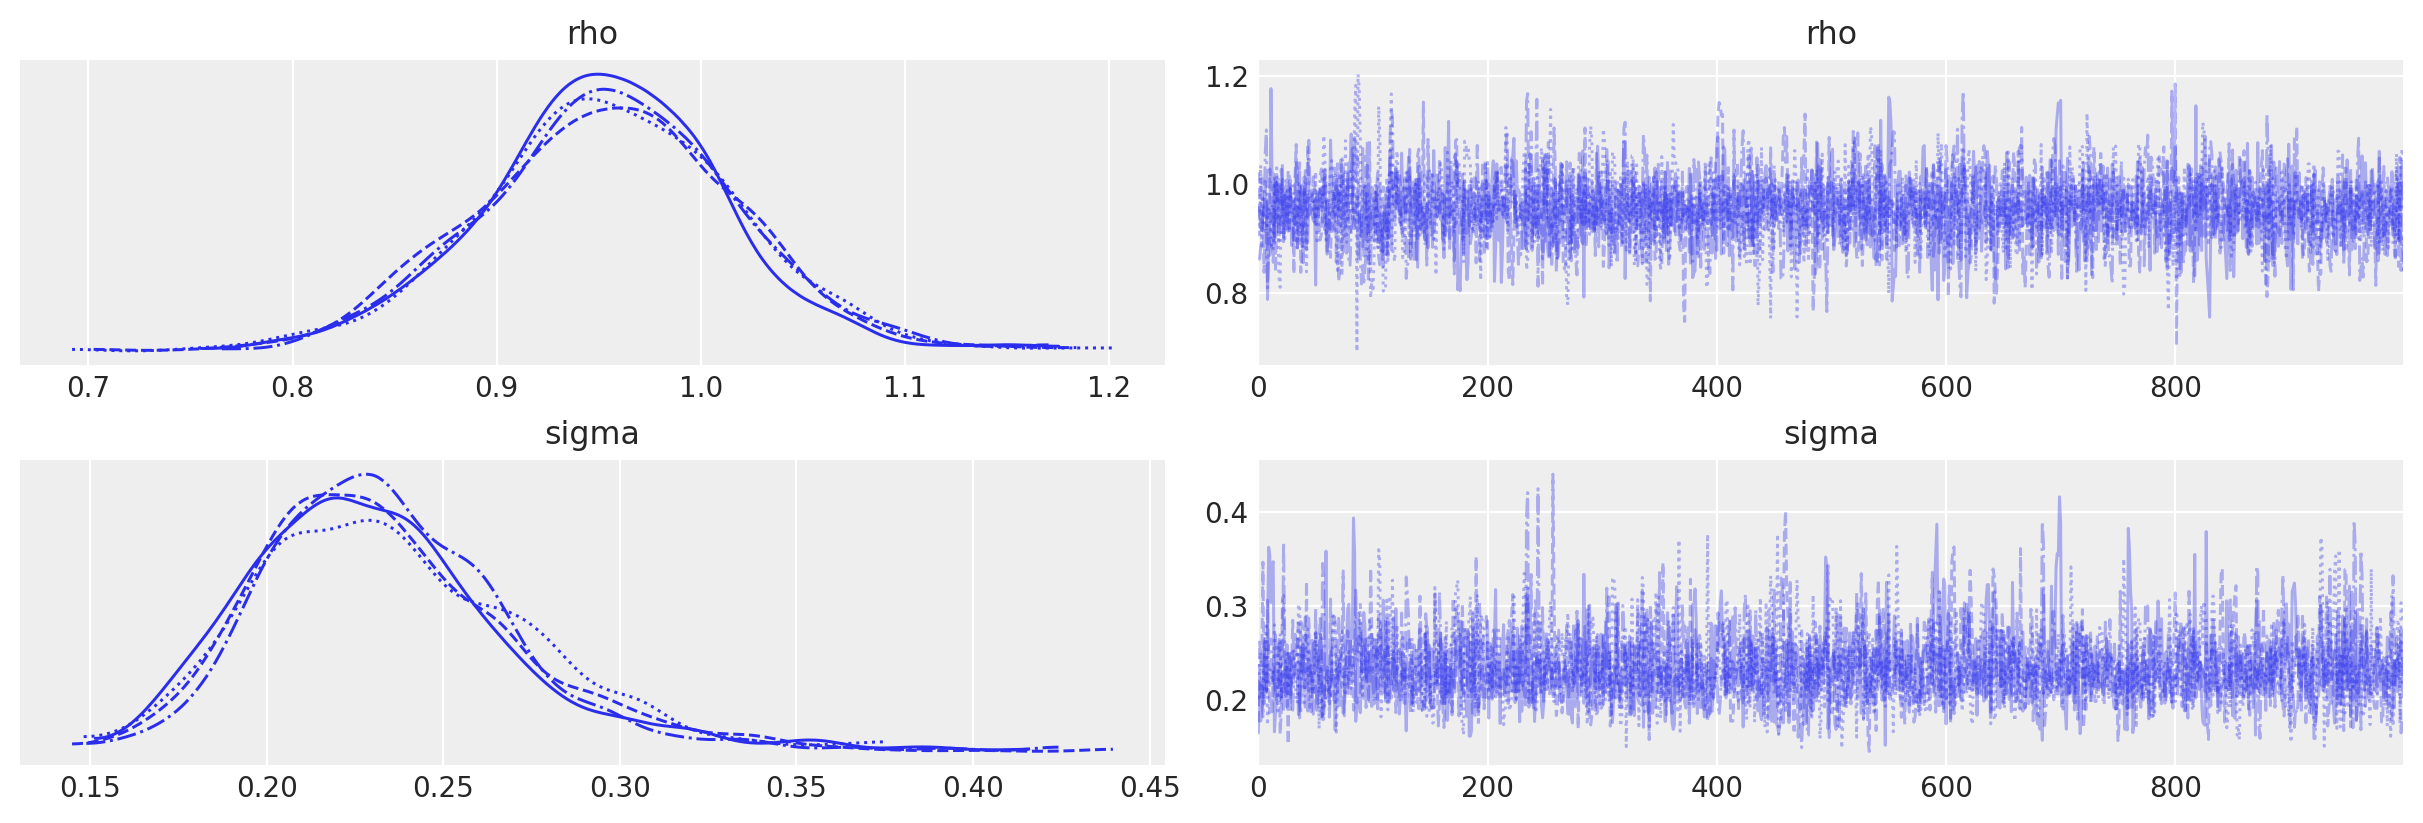

In [102]:
# AR(1) no constant
with pm.Model() as ar1nc:
    rho = pm.Normal("rho", 0.0, 1.0, shape=1)
    sigma = pm.HalfNormal("sigma", 3)
    likelihood = pm.AR(
        "y", rho=rho, sigma=sigma, constant=False, init_dist=pm.Normal.dist(0, 10), observed=y.iloc[0,:]
    )

    idata = pm.sample(
        1000,
        tune=2000,
        target_accept=0.9,
        random_seed=RANDOM_SEED,
    )
    
az.plot_trace(
    idata
);

In [100]:
# AR(2) no constant
with pm.Model() as ar2nc:
    rho = pm.Normal("rho", 0.0, 1.0, shape=2)
    sigma = pm.HalfNormal("sigma", 3)
    likelihood = pm.AR(
        "y", rho=rho, sigma=sigma, constant=False, init_dist=pm.Normal.dist(0, 10), observed=y.iloc[0,:]
    )

    idata = pm.sample(
        1000,
        tune=2000,
        target_accept=0.9,
        random_seed=RANDOM_SEED,
    )
    
az.plot_trace(
    idata
);

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:11

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.


## Estimer le nombre optimal de clusters K

en utilisant une prior uniforme pour M_k : Pr(MK)= 1/Kmax
 

Etape 1 : Bridge Sampling

In [88]:
import numpy as np
from scipy.stats import dirichlet

def bridge_sampling(log_posterior, log_prior, proposal_density, posterior_samples, proposal_samples):
    """
    Implémente la méthode de bridge sampling pour estimer la vraisemblance marginale.
    log_posterior: fonction qui calcule le log de la densité postérieure
    log_prior: fonction qui calcule le log de la prior
    proposal_density: fonction qui calcule la densité de la proposition
    posterior_samples: échantillons de la distribution postérieure (MCMC)
    proposal_samples: échantillons de la distribution de proposition (iid)
    """
    # Calcul des poids de bridge
    log_w_posterior = log_posterior(posterior_samples) + log_prior(posterior_samples) - proposal_density(posterior_samples)
    log_w_proposal = log_posterior(proposal_samples) + log_prior(proposal_samples) - proposal_density(proposal_samples)
    
    w_posterior = np.exp(log_w_posterior)
    w_proposal = np.exp(log_w_proposal)
    
    Z_ratio = np.sum(w_posterior) / np.sum(w_proposal)
    marginal_likelihood = np.sum(w_posterior / (Z_ratio + w_posterior))
    
    return np.log(marginal_likelihood)


Étape 2 : Intégration avec MCMC et choix de K

In [89]:
def compute_marginal_likelihood(y, K, num_iterations, p, q, e0=1.0):
    """
    Calcule la vraisemblance marginale pour un nombre donné de clusters K.
    """
    # Étape 1 : Échantillonnage MCMC pour le modèle avec K clusters
    S, theta, eta = mcmc_arma(y, K, p, q, num_iterations, e0)
    
    # Étape 2 : Définir les fonctions de log posterior, prior et proposition
    def log_posterior(params):
        # Placeholder : remplacez par le calcul du log posterior
        return -0.5 * np.sum(params**2)
    
    def log_prior(params):
        # Placeholder : prior sur les paramètres
        return -0.5 * np.sum(params**2)
    
    def proposal_density(params):
        # Placeholder : densité de proposition gaussienne
        return -0.5 * np.sum(params**2)
    
    # Étape 3 : Générer des échantillons pour bridge sampling
    posterior_samples = np.random.randn(1000, len(theta))  # Échantillons postérieurs simulés
    proposal_samples = np.random.randn(1000, len(theta))  # Échantillons de proposition
    
    # Étape 4 : Bridge sampling
    log_marginal_likelihood = bridge_sampling(log_posterior, log_prior, proposal_density, posterior_samples, proposal_samples)
    return log_marginal_likelihood


Étape 3 : Estimation du nombre optimal de clusters

In [90]:
def choose_optimal_clusters(y, K_max, num_iterations, p, q, e0=1.0):
    """
    Choisit le nombre optimal de clusters en utilisant la vraisemblance marginale.
    """
    log_marginal_likelihoods = []
    
    for K in range(1, K_max + 1):
        log_ml = compute_marginal_likelihood(y, K, num_iterations, p, q, e0)
        log_marginal_likelihoods.append(log_ml)
        print(f"K={K}, log marginal likelihood = {log_ml}")
    
    optimal_K = np.argmax(log_marginal_likelihoods) + 1
    return optimal_K, log_marginal_likelihoods


In [91]:
def choose_optimal_clusters_with_prior(y, K_max, num_iterations, p, q, e0=1.0):
    """
    Choisit le nombre optimal de clusters en utilisant la vraisemblance marginale
    avec une prior explicite sur les modèles.
    """
    log_marginal_likelihoods = []
    prior_probabilities = [1 / K_max] * K_max  # Prior uniforme

    for K in range(1, K_max + 1):
        log_ml = compute_marginal_likelihood(y, K, num_iterations, p, q, e0)
        log_prior = np.log(prior_probabilities[K - 1])
        log_marginal_likelihoods.append(log_ml + log_prior)
        print(f"K={K}, log marginal likelihood + log prior = {log_ml + log_prior}")

    optimal_K = np.argmax(log_marginal_likelihoods) + 1
    return optimal_K, log_marginal_likelihoods


Utilisation

In [87]:
# Exécution pour des données réelles normalisées sur l'ensemble
np.random.seed(42)

# Conversion en tableau NumPy
y_global = GDP_global_25.values.T  # Transpose pour avoir (N, T)
K_max = 10
num_iterations = 1000
p, q = 1, 1

optimal_K, log_marginal_likelihoods = choose_optimal_clusters_with_prior(y_global, K_max, num_iterations, p, q)
print(f"Nombre optimal de clusters : {optimal_K}")


Iteration 0: eta = [1.]
Iteration 100: eta = [1.]
Iteration 200: eta = [1.]
Iteration 300: eta = [1.]
Iteration 400: eta = [1.]
Iteration 500: eta = [1.]
Iteration 600: eta = [1.]
Iteration 700: eta = [1.]
Iteration 800: eta = [1.]
Iteration 900: eta = [1.]
K=1, log marginal likelihood + log prior = -506.63037858262845
Iteration 0: eta = [0.26478075 0.73521925]
Iteration 100: eta = [0.12587618 0.87412382]
Iteration 200: eta = [0.38767076 0.61232924]
Iteration 300: eta = [0.79586043 0.20413957]
Iteration 400: eta = [0.57810088 0.42189912]
Iteration 500: eta = [0.75718219 0.24281781]
Iteration 600: eta = [0.68836394 0.31163606]
Iteration 700: eta = [0.41571736 0.58428264]
Iteration 800: eta = [0.27223669 0.72776331]
Iteration 900: eta = [0.64557373 0.35442627]


C:\Users\hp\AppData\Local\Temp\ipykernel_12956\3997777796.py:20: RuntimeWarning: invalid value encountered in scalar divide
  Z_ratio = np.sum(w_posterior) / np.sum(w_proposal)


K=2, log marginal likelihood + log prior = nan
Iteration 0: eta = [0.46381527 0.45736827 0.07881646]
Iteration 100: eta = [0.06409691 0.69500333 0.24089976]
Iteration 200: eta = [0.6727733  0.31035314 0.01687356]
Iteration 300: eta = [0.17436685 0.25593848 0.56969467]
Iteration 400: eta = [0.00616875 0.56747018 0.42636107]
Iteration 500: eta = [0.46233875 0.02578251 0.51187874]
Iteration 600: eta = [0.4906374  0.1209427  0.38841989]
Iteration 700: eta = [0.00578596 0.48739303 0.50682101]
Iteration 800: eta = [0.08652585 0.59293892 0.32053523]
Iteration 900: eta = [0.45748703 0.15172928 0.39078368]
K=3, log marginal likelihood + log prior = nan
Iteration 0: eta = [0.1210421  0.26068525 0.18595499 0.43231766]
Iteration 100: eta = [0.08292567 0.50142407 0.2014924  0.21415787]
Iteration 200: eta = [0.37774112 0.06067071 0.16262365 0.39896452]
Iteration 300: eta = [0.13146601 0.33642341 0.52084928 0.0112613 ]
Iteration 400: eta = [0.28293227 0.16444583 0.29657572 0.25604618]
Iteration 500: 